# Windspeed Prediction for Surprise Storm

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

from ipywidgets import widgets, HBox
from torchvision.transforms import functional as TF
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from prediction import *

This is the hurricane dataset class. See other notebook for clarity on why it is written the way it is and why it differs from the data set class for the image generation task.

Below you can see the model architecture.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading
Creating a train set and loading it. Validation split is 0, ie there is no validation set. Idea is to overfit on the given data for the given storm so predictions for the windspeeds are only based on the storm given.

Our training data for the surprise storm only consisted of the surprise storm. We tried training on similar storm and then on the surprise storm but got better results when overfitting on this surprise storm.

We believe the predicted windspeeds match the images of the surprise. The images seem to show the storm dispersing. This is also shown in our predicted windspeed which have a downwards trend as seen on the plot on the right.

In [ ]:
from torch.utils.data import Subset, DataLoader
import numpy as np

np.random.seed(42)

def train_val_dataset(dataset, val_split=0.0):
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size

    indices = np.arange(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    datasets = {'train': Subset(dataset, train_indices), 'val': Subset(dataset, val_indices)}
    return datasets

def collate(batch):
    images = torch.stack([item[0] for item in batch], dim=0)
    labels = torch.tensor([float(item[1]) for item in batch], dtype=torch.float32)
    return images, labels

dataset = HurricaneDataset(image_folder='/content/train/tst_train', image_size=(64, 64), channels=1)
datasets = train_val_dataset(dataset)

train_loader = DataLoader(datasets['train'], batch_size=32, shuffle=True, collate_fn=collate)
val_loader = DataLoader(datasets['val'], batch_size=32, shuffle=False, collate_fn=collate)

In [10]:
model = Seq2Seq(num_channels=1, num_kernels=64,
                kernel_size=(3, 3), padding=(1, 1), activation="relu",
                frame_size=(64, 64), num_layers=3, fc_size=1024).to(device)


optimizer = Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss(reduction='mean')

## Model Training

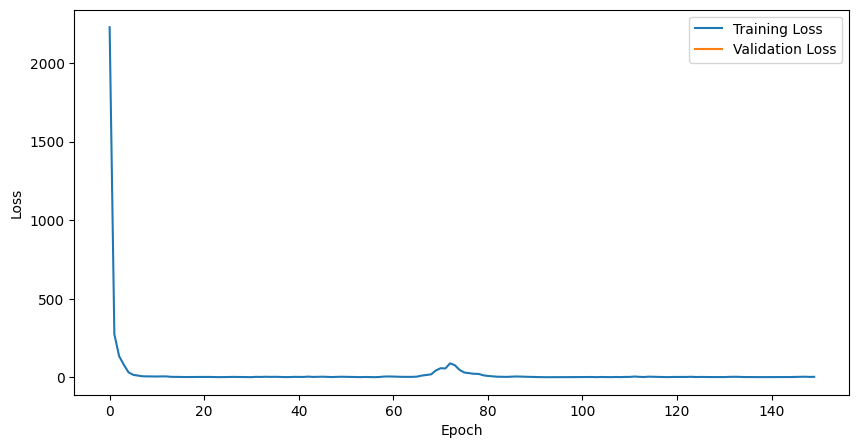

Epoch 150/150, Train Loss: 3.0520


In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

def train_model_with_plot(model, train_loader, criterion, optimizer, val_loader=None, num_epochs=25, device='cuda'):
    train_losses = []
    val_losses = []
    best_train_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1)

            optimizer.zero_grad()
            outputs = model(inputs).view(-1)

            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

        if train_loss < best_train_loss:
            best_train_loss = train_loss
            torch.save(model.state_dict(), '/content/models_real')
            print(f"Saved new best model at epoch {epoch+1}")

train_model_with_plot(model, train_loader, criterion, optimizer, num_epochs=150)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the model several times picked the model that seemed to make the most sense when visually inspecting the images and the linear pattern of decreasing windspeeds 10 or so frames before.

In [10]:
model = Seq2Seq(num_channels=1, num_kernels=64,
                kernel_size=(3, 3), padding=(1, 1), activation="relu",
                frame_size=(64, 64), num_layers=3, fc_size=1024).to(device)

# Load the saved weights
model.load_state_dict(torch.load('/content/drive/MyDrive/final_model_64_windspeed'))


<All keys matched successfully>

Below is a link to the final weights of the windspeed prediction model. The file is over a GB in size so adding it to the repository is unnecessary. If you have any issues with downloading or accessing the file please contact [Antony Krymski](#Authors).<br>
https://drive.google.com/file/d/1-Y5q_6vkOF3gMr3fCXDXpElT0Be5WUoc/view?usp=sharing

## Model Predictions on Surprise Storm

Running predictions on test set which is all the images and json files for the last 10 windspeeds but no labels.

In [47]:
def get_predictions(model, data_loader, device='cuda'):
    model.eval()
    predictions = []
    image_filenames = []

    prefix_to_remove = '/content/test_data_new/tst_test/'

    with torch.no_grad():
        for data in data_loader:
            if len(data) == 2:
                inputs, filenames = data
                targets = None
            else:
                inputs, targets, filenames = data

            inputs = inputs.to(device)
            outputs = model(inputs)

            predictions.extend(outputs.view(-1).cpu().numpy())
            image_filenames.extend([filename.replace(prefix_to_remove, '') for filename in filenames])

    return image_filenames, predictions

test_dataset = HurricaneDataset(image_folder='/content/test_data_new/tst_test', image_size=(64, 64), mode='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

image_filenames, predicted_wind_speeds = get_predictions(model, test_loader)


In [48]:
data = {
    "Image Filename": image_filenames,
    "Predicted Wind Speed": np.round(predicted_wind_speeds)
}

results_df = pd.DataFrame(data)
print(results_df)

  Image Filename  Predicted Wind Speed
0    tst_242.jpg                  59.0
1    tst_243.jpg                  58.0
2    tst_244.jpg                  57.0
3    tst_245.jpg                  56.0
4    tst_246.jpg                  56.0
5    tst_247.jpg                  54.0
6    tst_248.jpg                  54.0
7    tst_249.jpg                  53.0
8    tst_250.jpg                  52.0
9    tst_251.jpg                  51.0


Below you can see some code to plot the given data and the predicted windspeeds just to be able to visually the trend of the windspeed.

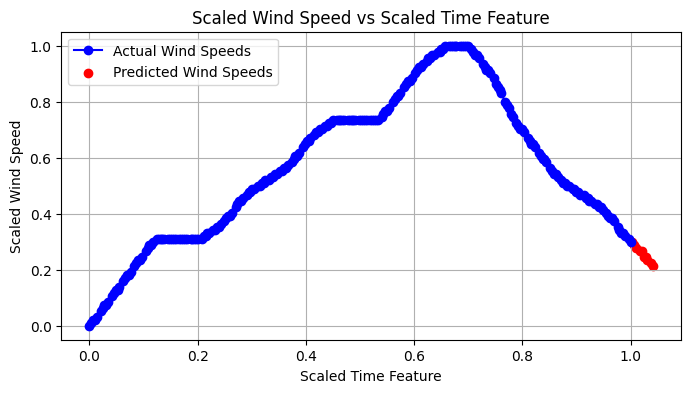

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

additional_time_features = np.array([522000, 523800, 525601, 529199, 530999, 532799, 534599, 536398, 539999, 541799])
additional_predicted_wind_speeds = np.array([59.0, 58.0, 57.0, 56.0, 56.0, 54.0, 54.0, 53.0, 52.0, 51.0])

directory = '/content/sample_data/train/tst_train'

wind_speeds = []
time_features = []

all_files = sorted(os.listdir(directory))

for file in all_files:
    if file.endswith('_label.json'):
        with open(os.path.join(directory, file), 'r') as f:
            label_data = json.load(f)
            wind_speeds.append(label_data['wind_speed'])
    elif file.endswith('_features.json'):
        with open(os.path.join(directory, file), 'r') as f:
            features_data = json.load(f)
            time_features.append(features_data['relative_time'])  # Replace with actual key

wind_speeds_np = np.array(wind_speeds).reshape(-1, 1)
time_features_np = np.array(time_features).reshape(-1, 1)

time_scaler = MinMaxScaler()
wind_speed_scaler = MinMaxScaler()
time_scaler.fit(time_features_np)
wind_speed_scaler.fit(wind_speeds_np)

time_features_scaled = time_scaler.transform(time_features_np)
wind_speeds_scaled = wind_speed_scaler.transform(wind_speeds_np)

additional_time_features_scaled = time_scaler.transform(additional_time_features.reshape(-1, 1))
additional_predicted_wind_speeds_scaled = wind_speed_scaler.transform(additional_predicted_wind_speeds.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.plot(time_features_scaled, wind_speeds_scaled, marker='o', color='blue', label='Actual Wind Speeds')
plt.scatter(additional_time_features_scaled, additional_predicted_wind_speeds_scaled, color='red', label='Predicted Wind Speeds')
plt.title('Scaled Wind Speed vs Scaled Time Feature')
plt.xlabel('Scaled Time Feature')
plt.ylabel('Scaled Wind Speed')
plt.legend()
plt.grid(True)
plt.show()


Above you can see a clear trend that the windspeeds are decreasing. Looking at the overall trend of the plot it makes sense that is the case.

Getting windspeeds for predicted images from image generation model (see other notebook).

In [41]:
def get_predictions(model, data_loader, device='cuda'):
    model.eval()
    predictions = []
    image_filenames = []

    prefix_to_remove = '/content/test_genimages/test_genimages/'

    with torch.no_grad():
        for data in data_loader:
            if len(data) == 2:
                inputs, filenames = data
                targets = None
            else:
                inputs, targets, filenames = data

            inputs = inputs.to(device)
            outputs = model(inputs)

            predictions.extend(outputs.view(-1).cpu().numpy())
            image_filenames.extend([filename.replace(prefix_to_remove, '') for filename in filenames])

    return image_filenames, predictions

test_dataset = HurricaneDataset(image_folder='/content/test_genimages/test_genimages', image_size=(64, 64), mode='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

image_filenames, predicted_wind_speeds = get_predictions(model, test_loader)


Final wind speed predictions on generated images can be seen below.

In [42]:
data = {
    "Image Filename": image_filenames,
    "Predicted Wind Speed": np.round(predicted_wind_speeds)
}

results_df = pd.DataFrame(data)
print(results_df)

  Image Filename  Predicted Wind Speed
0    tst_252.jpg                  53.0
1    tst_253.jpg                  55.0
2    tst_254.jpg                  57.0


Here we can see the pattern deviated and the windspeed started increasing. There are a couple of potential reasons for this:

- The quality of the 3 predicted images decreases with each image. This is due to the nature of the image generation model which uses a sliding window and recursively predicts the next image. Therefore, each predicted image is reused as part of the input.
- Not only has the quality worsened, but due to the blurriness the images have more grey/white pixels. This may cause the windspeed model to think there are more clouds than there actually are. This results in the model potentially thinking that the cyclone may be starting up again which leads to the increase in windspeed.
- It is worth noting that the windspeed do not increase dramatically and looking at previous storms, tropical cyclones can be unpredictable and an uptick near the end of the cyclone is very much plausible.